Initial Dataset Loading

In [ ]:
# All packages I needed to install
#%pip install librosa

## It is necessary to run
# sudo apt install portaudio19-dev 
## before attempting to install pyaudio in Ubuntu

#%pip install pyaudio

In [69]:
import librosa
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input
from tensorflow.keras.optimizers import Adam
import socket
import sys
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
import soundfile as sf
import io
import threading
import pyaudio
import sounddevice as sd
import kafka
from pyspark.sql import SparkSession
from keras.models import load_model
from confluent_kafka import Producer

In [70]:
# Define the path to the main dataset directory containing 'fold1' to 'fold10'
dataset_dir = r'C:\Users\Paul\Downloads\Masters\MSc_DA_CA3\UrbanSound8K\UrbanSound8K\audio'


In [71]:

# Create extract_features() function
# This function will extract features from a single sound file, such as the MFCCs.
# It takes 1 parameter:
#     file_name: the path to the sound file
# It returns 1 value:
#     features: a numpy array of sound features

def extract_features(file_path, metadata):
    # Extract the class label based on the file name
    file_name = os.path.basename(file_path)
    class_label = metadata[metadata['slice_file_name'] == file_name]['class'].values[0]

    # Load the audio file
    audio, _ = librosa.load(file_path, res_type='kaiser_fast')

    # Extract features (e.g., Mel-frequency cepstral coefficients)
    mfccs = librosa.feature.mfcc(y=audio, sr=22050, n_mfcc=13)

    # Flatten the feature matrix
    mfccs = np.mean(mfccs.T, axis=0)

    return mfccs, class_label


In [72]:
# Create an empty list of features and labels
feature_list = []
label_list = []

In [18]:
# Get the list of folders in the main dataset directory
 # THIS WILL TAKE 7 MINS TO RUN 
for folder in os.listdir(dataset_dir):
    if folder.startswith('fold'):
        folder_path = os.path.join(dataset_dir, folder)
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.wav'):
                file_path = os.path.join(folder_path, file_name)
                features, class_label = extract_features(file_path, metadata)
                feature_list.append(features)
                label_list.append(class_label)


c:\Users\Paul\anaconda3\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
c:\Users\Paul\anaconda3\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
c:\Users\Paul\anaconda3\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


In [19]:
# Save Envirnmental Sound Classification features and labels to disk
np.save('features.npy', feature_list)
np.save('labels.npy', label_list)

In [73]:
# Load features and labels (to save time during development)
features = np.load('features.npy', allow_pickle=True)
labels = np.load('labels.npy', allow_pickle=True)

EDA

In [74]:
# Examine the size of the feature list
print('Number of feature vectors:', len(features))

Number of feature vectors: 8732


In [75]:
# Are the feature vectors all the same size?
print('Feature vector length:', len(features[0]))

Feature vector length: 13


In [76]:
# perform a t-test to see if the means of the feature vectors for two classes are significantly different
# Define two classes to compare
class_1 = 'children_playing'
class_2 = 'dog_bark'

# Get the list of class labels
class_labels = list(set(labels))
feature_list = features
label_list = labels

# Get the list of feature vectors for each class
class_1_features = [feature_list[i] for i in range(len(feature_list)) if label_list[i] == class_1]

class_2_features = [feature_list[i] for i in range(len(feature_list)) if label_list[i] == class_2]

# Perform t-test
t, p = ttest_ind(class_1_features, class_2_features)

# Print the results of the t-test
print('t = ' + str(t))
print('p = ' + str(p))

# Create a Pandas DataFrame to hold the feature vectors and class labels
features_df = pd.DataFrame(features)
features_df['class'] = labels

# Examine the DataFrame
features_df.head()

# Examine the distribution of class labels
features_df['class'].value_counts()

t = [  7.244904    1.7617097  -8.681273   28.510284    2.9328039  16.502254
   8.040186    8.366528    2.0879772   8.151978  -11.47768    10.624021
  -8.941257 ]
p = [6.1511722e-13 7.8271277e-02 7.9738598e-18 0.0000000e+00 3.3973907e-03
 0.0000000e+00 1.5204587e-15 1.0989711e-16 3.6926255e-02 6.2482132e-16
 1.4121243e-29 1.1006975e-25 8.5504104e-19]


dog_bark            1000
jackhammer          1000
engine_idling       1000
children_playing    1000
street_music        1000
air_conditioner     1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

In [77]:
# Add feature names to DataFrame
feature_names = ['mfcc' + str(i) for i in range(1, 14)]
feature_names.append('class')
features_df.columns = feature_names

# Examine the DataFrame
features_df.head()

,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,class
0,-403.450775,93.772453,17.812965,-11.735518,-7.220359,3.765296,-16.174644,-6.859319,-10.542679,-5.188827,0.041710,-4.935716,0.938063,dog_bark
1,-367.814758,128.261002,29.322836,-21.599026,-14.891522,2.339720,-28.616245,-17.765814,-23.516216,-8.776717,1.006966,-4.489775,4.392671,dog_bark
2,-422.120544,69.941666,9.877000,0.094108,1.648382,3.525948,-9.561525,-1.859950,-3.891847,-0.314790,3.337800,0.717791,-1.352891,dog_bark
3,-259.886444,107.981140,-50.568455,-5.474560,-17.245996,1.901729,-6.068827,6.973870,0.355850,12.182370,-0.023248,24.034210,-4.974939,dog_bark
4,-386.498505,131.816086,26.007700,22.088737,-9.809354,3.992721,-6.131800,8.991668,-0.286275,7.668528,-4.322468,2.864880,0.418705,gun_shot


In [78]:
# Create a list of meaningful column names based on MFCC descriptions
mfcc_column_names = [
    'mfcc_energy',
    'mfcc_spectral_low1',
    'mfcc_spectral_mid1',
    'mfcc_spectral_mid2',
    'mfcc_spectral_mid3',
    'mfcc_spectral_high1',
    'mfcc_spectral_high2',
    'mfcc_spectral_high3',
    'mfcc_spectral_high4',
    'mfcc_spectral_high5',
    'mfcc_detail1',
    'mfcc_detail2',
    'mfcc_detail3',
    'class'
]

# Assign the created column names to the features DataFrame
features_df.columns = mfcc_column_names

                fsID        start          end     salience         fold  \
count    8732.000000  8732.000000  8732.000000  8732.000000  8732.000000   
mean   116033.493816    38.645409    42.253312     1.347000     5.385937   
std     57991.017218    74.292126    74.369669     0.476043     2.846820   
min       344.000000     0.000000     0.105962     1.000000     1.000000   
25%     69942.250000     3.000000     6.839398     1.000000     3.000000   
50%    118279.000000    10.376492    14.000000     1.000000     5.000000   
75%    166942.000000    35.131372    38.866979     2.000000     8.000000   
max    209992.000000   600.125356   604.125356     2.000000    10.000000   

           classID  
count  8732.000000  
mean      4.592877  
std       2.894544  
min       0.000000  
25%       2.000000  
50%       4.000000  
75%       7.000000  
max       9.000000  
slice_file_name    0
fsID               0
start              0
end                0
salience           0
fold               0


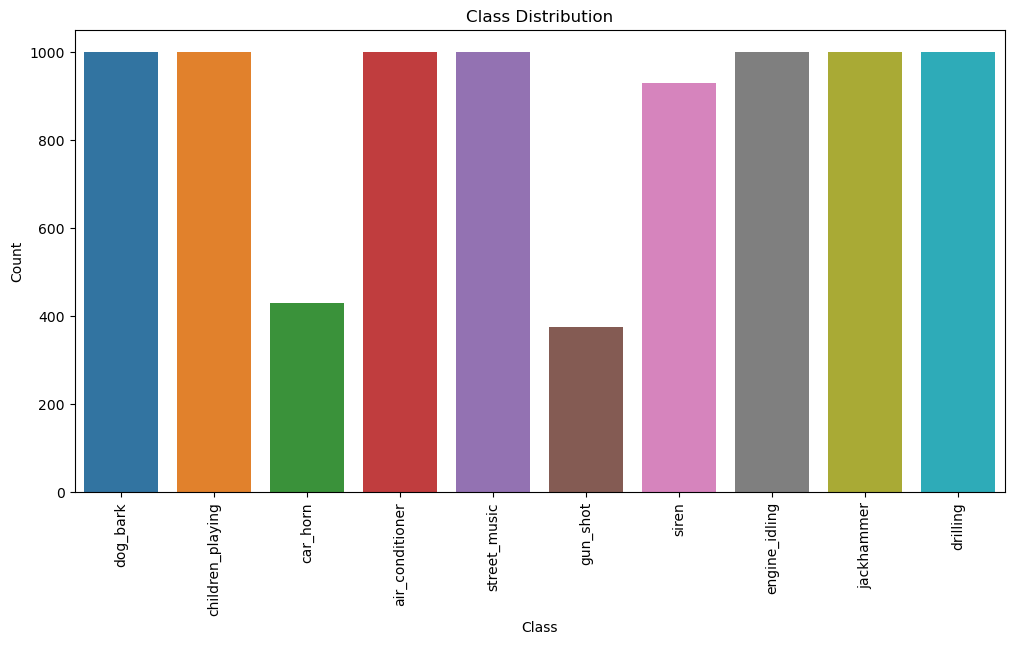

       mfcc_energy  mfcc_spectral_low1  mfcc_spectral_mid1  \
count  8732.000000         8732.000000         8732.000000   
mean   -230.184631          114.321854          -27.656820   
std     129.707123           48.001690           31.378609   
min    -766.317749          -64.599388         -165.692215   
25%    -313.787605           86.691669          -44.714517   
50%    -217.100456          120.122486          -24.517739   
75%    -131.428020          147.059368           -8.226402   
max     129.532166          276.579529           83.811600   

       mfcc_spectral_mid2  mfcc_spectral_mid3  mfcc_spectral_high1  \
count         8732.000000         8732.000000          8732.000000   
mean            20.384014          -12.987039            14.454811   
std             21.766222           15.723857            14.681323   
min            -79.691612          -99.794167           -58.930050   
25%              9.304368          -23.082563             6.195792   
50%             23.09

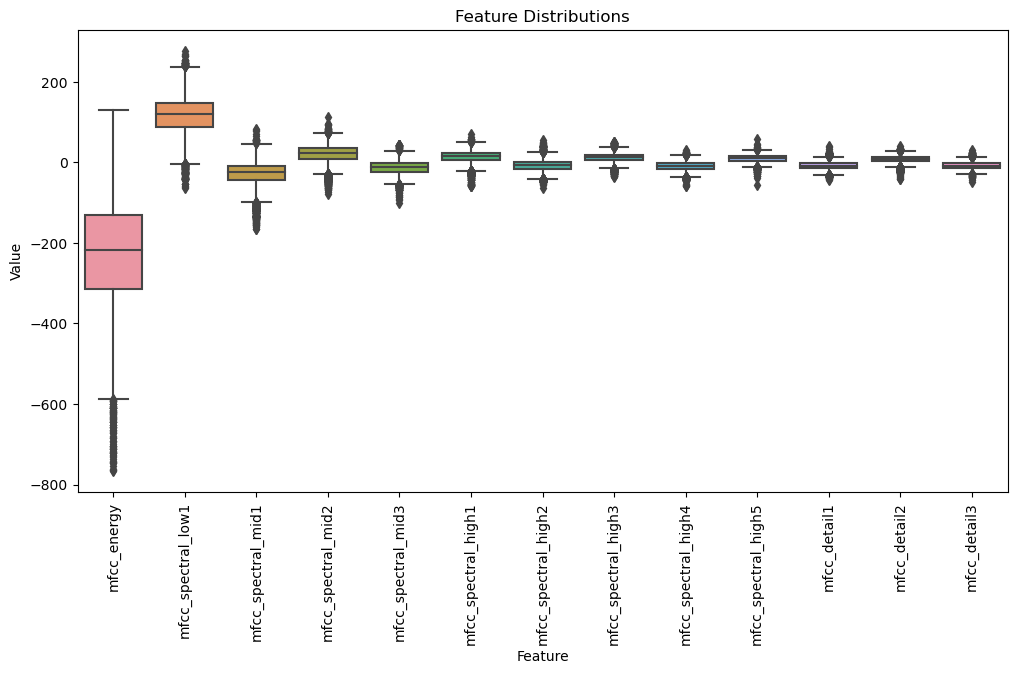

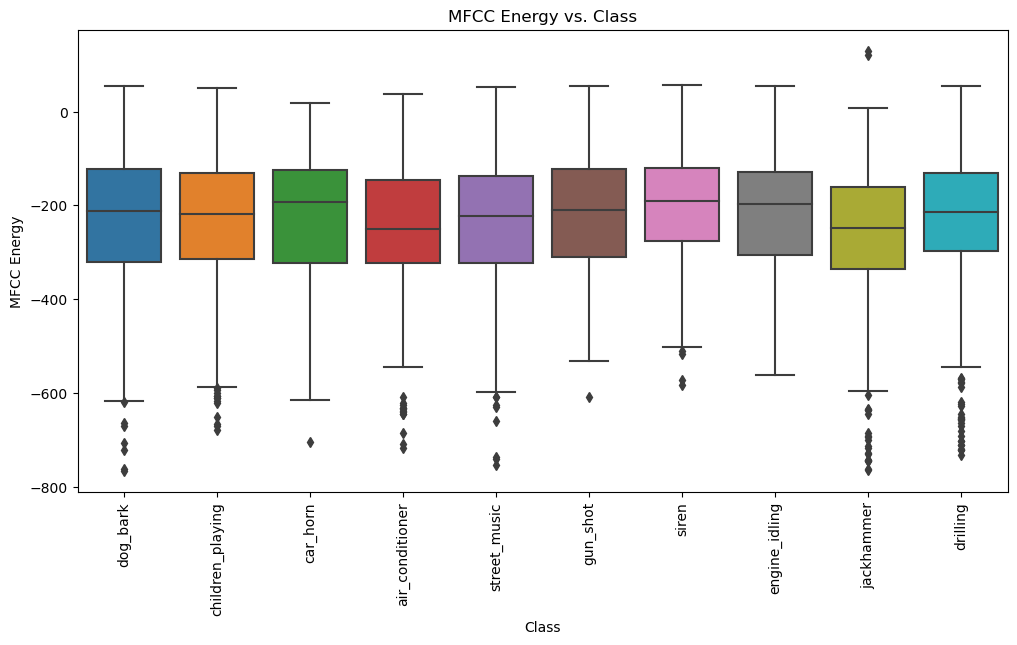

Test for class dog_bark: t-statistic=0.36192885328845226, p-value=0.7174139576060821
Test for class children_playing: t-statistic=0.3428966815776828, p-value=0.7316844442872972
Test for class car_horn: t-statistic=1.3675435720991733, p-value=0.17149019422392164
Test for class air_conditioner: t-statistic=-4.046567321229036, p-value=5.2422395017633404e-05
Test for class street_music: t-statistic=-2.674581050148306, p-value=0.007496209967690917
Test for class gun_shot: t-statistic=2.101028221427894, p-value=0.03566708602241529
Test for class siren: t-statistic=7.137707769257521, p-value=1.0248855524025598e-12
Test for class engine_idling: t-statistic=3.756710587912719, p-value=0.00017328188220103283
Test for class jackhammer: t-statistic=-7.317773855783848, p-value=2.7443525119233534e-13
Test for class drilling: t-statistic=0.3984356822897764, p-value=0.6903188038090458


In [79]:
# Load the CSV file with metadata

metadata = pd.read_csv('UrbanSound8K.csv')

# Display basic statistics about the dataset
print(metadata.describe())

# Check for missing values
print(metadata.isnull().sum())

# Visualize class distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=metadata, x='class')
plt.xticks(rotation=90)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Display basic statistics about the features
print(features_df.describe())

# Visualize feature distributions
plt.figure(figsize=(12, 6))
sns.boxplot(data=features_df.drop(columns=['class']))
plt.title('Feature Distributions')
plt.xlabel('Feature')
plt.ylabel('Value')
plt.xticks(rotation=90)
plt.show()

# Explore relationships between features and class labels
merged_data = pd.concat([features_df.drop(columns=['class']), metadata['class']], axis=1)
plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_data, x='class', y='mfcc_energy')  
plt.title('MFCC Energy vs. Class')
plt.xlabel('Class')
plt.ylabel('MFCC Energy')
plt.xticks(rotation=90)
plt.show()

# Perform statistical tests (e.g., t-tests or ANOVA) to assess feature significance
from scipy.stats import ttest_ind

class_labels = metadata['class'].unique()
for label in class_labels:
    group1 = features_df[metadata['class'] == label]['mfcc_energy']
    group2 = features_df[metadata['class'] != label]['mfcc_energy']
    t_stat, p_value = ttest_ind(group1, group2)
    print(f'Test for class {label}: t-statistic={t_stat}, p-value={p_value}')


In [80]:
# Perform Anova tests to list classes that are significantly different from each other

# Define the significance level
alpha = 0.05

class_labels = metadata['class'].unique()

for mfcc_column_name in mfcc_column_names:
    print(f"Testing significance for feature column: {mfcc_column_name}")
    for label in class_labels:
        group1 = features_df[metadata['class'] == label][mfcc_column_name]
        group2 = features_df[metadata['class'] != label][mfcc_column_name]
        t_stat, p_value = ttest_ind(group1, group2)
        if p_value < alpha:
            print(f'Test for class {label}: t-statistic={t_stat}, p-value={p_value}') # Reject null hypothesis
    print("\n")

Testing significance for feature column: mfcc_energy
Test for class air_conditioner: t-statistic=-4.046567321229036, p-value=5.2422395017633404e-05
Test for class street_music: t-statistic=-2.674581050148306, p-value=0.007496209967690917
Test for class gun_shot: t-statistic=2.101028221427894, p-value=0.03566708602241529
Test for class siren: t-statistic=7.137707769257521, p-value=1.0248855524025598e-12
Test for class engine_idling: t-statistic=3.756710587912719, p-value=0.00017328188220103283
Test for class jackhammer: t-statistic=-7.317773855783848, p-value=2.7443525119233534e-13


Testing significance for feature column: mfcc_spectral_low1
Test for class dog_bark: t-statistic=-2.5122938309291096, p-value=0.012012803433766601
Test for class car_horn: t-statistic=-2.831892669453514, p-value=0.004637928784580187
Test for class air_conditioner: t-statistic=2.6064278970888974, p-value=0.00916475428894602
Test for class street_music: t-statistic=-2.252410770307752, p-value=0.02432106231411

TypeError: unsupported operand type(s) for /: 'str' and 'int'

Sound Classfication Model

In [30]:
# Convert lists to NumPy arrays
X = np.array(feature_list)
y = np.array(label_list)

# Encode class labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Define the deep learning model
# Define the input layer
inputs = Input(shape=(X_train.shape[1],))

# Add a dense layer
dense = Dense(128, activation='relu')(inputs)

# Add the output layer
outputs = Dense(num_classes, activation='softmax')(dense)

# Define the model
model = keras.Model(
    inputs=inputs,
    outputs=outputs
)
    
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=2)

Epoch 1/50
175/175 - 1s - loss: 4.6966 - accuracy: 0.3304 - val_loss: 1.9756 - val_accuracy: 0.4488 - 999ms/epoch - 6ms/step
Epoch 2/50
175/175 - 0s - loss: 1.7895 - accuracy: 0.4717 - val_loss: 1.6754 - val_accuracy: 0.4939 - 316ms/epoch - 2ms/step
Epoch 3/50
175/175 - 0s - loss: 1.5504 - accuracy: 0.5082 - val_loss: 1.4889 - val_accuracy: 0.5383 - 315ms/epoch - 2ms/step
Epoch 4/50
175/175 - 0s - loss: 1.3978 - accuracy: 0.5471 - val_loss: 1.4298 - val_accuracy: 0.5369 - 411ms/epoch - 2ms/step
Epoch 5/50
175/175 - 0s - loss: 1.3435 - accuracy: 0.5693 - val_loss: 1.3794 - val_accuracy: 0.5569 - 346ms/epoch - 2ms/step
Epoch 6/50
175/175 - 0s - loss: 1.3093 - accuracy: 0.5718 - val_loss: 1.3818 - val_accuracy: 0.5641 - 337ms/epoch - 2ms/step
Epoch 7/50
175/175 - 0s - loss: 1.2948 - accuracy: 0.5798 - val_loss: 1.2579 - val_accuracy: 0.5870 - 340ms/epoch - 2ms/step
Epoch 8/50
175/175 - 0s - loss: 1.2206 - accuracy: 0.5948 - val_loss: 1.3653 - val_accuracy: 0.5741 - 342ms/epoch - 2ms/step


In [31]:
model.save('UrbanSound8K_model1.h5')

Epoch 1/50
175/175 - 2s - loss: 9.8237 - accuracy: 0.1355 - val_loss: 2.2530 - val_accuracy: 0.1518 - 2s/epoch - 9ms/step
Epoch 2/50
175/175 - 0s - loss: 2.3972 - accuracy: 0.1446 - val_loss: 2.2402 - val_accuracy: 0.1360 - 430ms/epoch - 2ms/step
Epoch 3/50
175/175 - 1s - loss: 2.2798 - accuracy: 0.1639 - val_loss: 2.1914 - val_accuracy: 0.1654 - 700ms/epoch - 4ms/step
Epoch 4/50
175/175 - 1s - loss: 2.1938 - accuracy: 0.1822 - val_loss: 2.1417 - val_accuracy: 0.1739 - 970ms/epoch - 6ms/step
Epoch 5/50
175/175 - 1s - loss: 2.1778 - accuracy: 0.1881 - val_loss: 2.0642 - val_accuracy: 0.2026 - 514ms/epoch - 3ms/step
Epoch 6/50
175/175 - 1s - loss: 2.1595 - accuracy: 0.2033 - val_loss: 2.0545 - val_accuracy: 0.2076 - 506ms/epoch - 3ms/step
Epoch 7/50
175/175 - 1s - loss: 2.1184 - accuracy: 0.2101 - val_loss: 2.0200 - val_accuracy: 0.2334 - 591ms/epoch - 3ms/step
Epoch 8/50
175/175 - 0s - loss: 2.0923 - accuracy: 0.2371 - val_loss: 1.9718 - val_accuracy: 0.2713 - 491ms/epoch - 3ms/step
Epo

/home/hduser/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Confusion Matrix:
[[146   0  27   0   2  11   0  17   2   6]
 [  4  37   3   2   4   4   0   5   5  13]
 [  9   0 153   6   2   4   0   1  10  12]
 [ 10   1  29 136   2   3   0   0  16  20]
 [  2   6  29   5 117   2   0  20   0  21]
 [ 24   1   8   0   1 148   0   1   6   4]
 [  2   0  17  26   1   0  18   0   4   4]
 [  4   0   3   0   2   5   0 185   0  10]
 [  0   0  27   8   0   2   0   2 140   1]
 [ 16   0  49   4   4  11   0   8   4  93]]

Classification Report:
                  precision    recall  f1-score   support

 air_conditioner       0.67      0.69      0.68       211
        car_horn       0.82      0.48      0.61        77
children_playing       0.44      0.78      0.56       197
        dog_bark       0.73      0.63      0.67       217
        drilling       0.87      0.58      0.69       202
   engine_idling       0.78      0.77      0.77       193
        gun_shot       1.00      0.25      0.40        72
      jackhammer       0.77      0.89      0.83       209
    

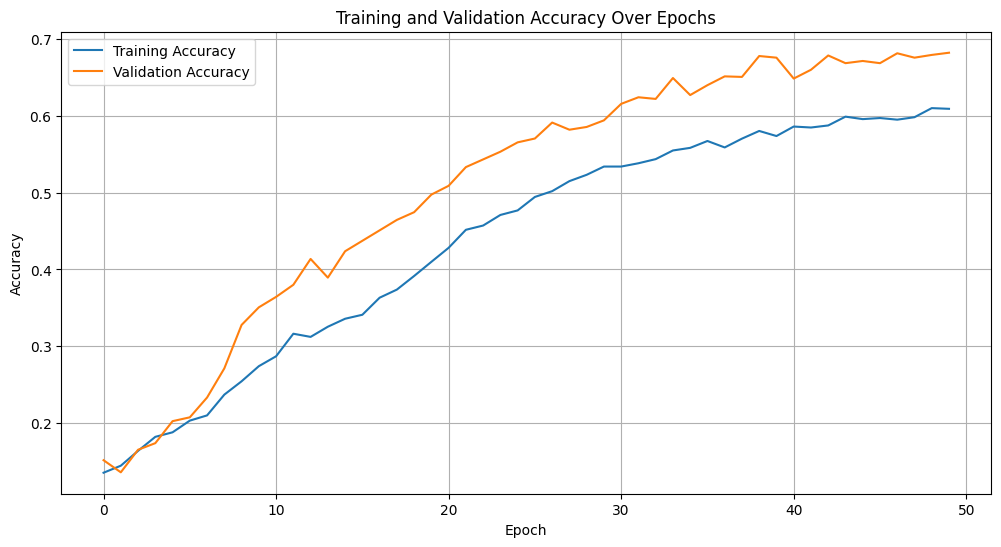

In [36]:
# Convert lists to NumPy arrays
X = np.array(feature_list)
y = np.array(label_list)

# Encode class labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Define the deep learning model
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=2)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}')

# Generate predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Decode class labels
y_test_labels = label_encoder.inverse_transform(y_test)
y_pred_labels = label_encoder.inverse_transform(y_pred_classes)

# Create a confusion matrix and classification report
confusion = confusion_matrix(y_test_labels, y_pred_labels)
classification_rep = classification_report(y_test_labels, y_pred_labels, target_names=label_encoder.classes_)

# Save the model
model.save('UrbanSound8K_model.h5')

print("Confusion Matrix:")
print(confusion)
print("\nClassification Report:")
print(classification_rep)

# Visualize training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid()
plt.show()

Epoch 1/50
175/175 - 2s - loss: 9.8237 - accuracy: 0.1355 - val_loss: 2.2530 - val_accuracy: 0.1518 - 2s/epoch - 9ms/step
Epoch 2/50
175/175 - 0s - loss: 2.3972 - accuracy: 0.1446 - val_loss: 2.2402 - val_accuracy: 0.1360 - 430ms/epoch - 2ms/step
Epoch 3/50
175/175 - 1s - loss: 2.2798 - accuracy: 0.1639 - val_loss: 2.1914 - val_accuracy: 0.1654 - 700ms/epoch - 4ms/step
Epoch 4/50
175/175 - 1s - loss: 2.1938 - accuracy: 0.1822 - val_loss: 2.1417 - val_accuracy: 0.1739 - 970ms/epoch - 6ms/step
Epoch 5/50
175/175 - 1s - loss: 2.1778 - accuracy: 0.1881 - val_loss: 2.0642 - val_accuracy: 0.2026 - 514ms/epoch - 3ms/step
Epoch 6/50
175/175 - 1s - loss: 2.1595 - accuracy: 0.2033 - val_loss: 2.0545 - val_accuracy: 0.2076 - 506ms/epoch - 3ms/step
Epoch 7/50
175/175 - 1s - loss: 2.1184 - accuracy: 0.2101 - val_loss: 2.0200 - val_accuracy: 0.2334 - 591ms/epoch - 3ms/step
Epoch 8/50
175/175 - 0s - loss: 2.0923 - accuracy: 0.2371 - val_loss: 1.9718 - val_accuracy: 0.2713 - 491ms/epoch - 3ms/step
Epo

/home/hduser/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Confusion Matrix:
[[146   0  27   0   2  11   0  17   2   6]
 [  4  37   3   2   4   4   0   5   5  13]
 [  9   0 153   6   2   4   0   1  10  12]
 [ 10   1  29 136   2   3   0   0  16  20]
 [  2   6  29   5 117   2   0  20   0  21]
 [ 24   1   8   0   1 148   0   1   6   4]
 [  2   0  17  26   1   0  18   0   4   4]
 [  4   0   3   0   2   5   0 185   0  10]
 [  0   0  27   8   0   2   0   2 140   1]
 [ 16   0  49   4   4  11   0   8   4  93]]

Classification Report:
                  precision    recall  f1-score   support

 air_conditioner       0.67      0.69      0.68       211
        car_horn       0.82      0.48      0.61        77
children_playing       0.44      0.78      0.56       197
        dog_bark       0.73      0.63      0.67       217
        drilling       0.87      0.58      0.69       202
   engine_idling       0.78      0.77      0.77       193
        gun_shot       1.00      0.25      0.40        72
      jackhammer       0.77      0.89      0.83       209
    

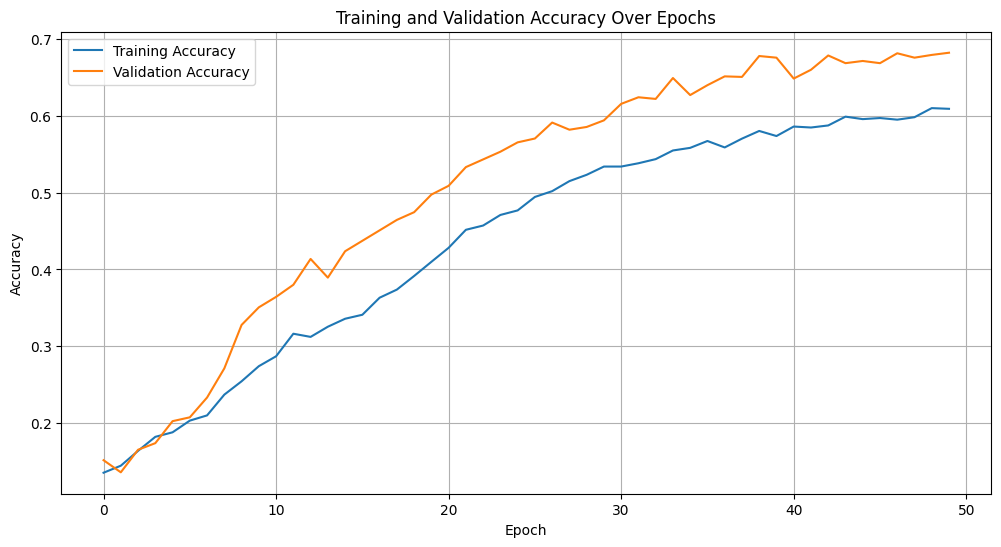

In [ ]:
# Convert lists to NumPy arrays
X = np.array(feature_list)
y = np.array(label_list)

# Encode class labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Define the deep learning model
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=2)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}')

# Generate predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Decode class labels
y_test_labels = label_encoder.inverse_transform(y_test)
y_pred_labels = label_encoder.inverse_transform(y_pred_classes)

# Create a confusion matrix and classification report
confusion = confusion_matrix(y_test_labels, y_pred_labels)
classification_rep = classification_report(y_test_labels, y_pred_labels, target_names=label_encoder.classes_)

# Save the model
model.save('UrbanSound8K_model.h5')

print("Confusion Matrix:")
print(confusion)
print("\nClassification Report:")
print(classification_rep)

# Visualize training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid()
plt.show()

/home/hduser/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Fold 1:
Training Loss: 0.7011
Training Accuracy: 0.7746
Testing Loss: 0.7735
Testing Accuracy: 0.7574
----------------------------------------


Fold 2:
Training Loss: 0.7098
Training Accuracy: 0.7690
Testing Loss: 0.7747
Testing Accuracy: 0.7471
----------------------------------------


Fold 3:
Training Loss: 0.7066
Training Accuracy: 0.7825
Testing Loss: 0.8122
Testing Accuracy: 0.7388
----------------------------------------


Fold 4:
Training Loss: 0.7134
Training Accuracy: 0.7669
Testing Loss: 0.7893
Testing Accuracy: 0.7549
----------------------------------------


Fold 5:
Training Loss: 0.7119
Training Accuracy: 0.7711
Testing Loss: 0.7321
Testing Accuracy: 0.7698
----------------------------------------


Fold 6:
Training Loss: 0.7215
Training Accuracy: 0.7685
Testing Loss: 0.7581
Testing Accuracy: 0.7503
----------------------------------------


Fold 7:
Training Loss: 0.6900
Training Accuracy: 0.7808
Testing Loss: 0.8063
Testing Accuracy: 0.7480
----------------------------------------


Fold 8:
Training Loss: 0.7092
Training Accuracy: 0.7771
Testing Loss: 0.7853
Testing Accuracy: 0.7434
----------------------------------------


Fold 9:
Training Loss: 0.7152
Training Accuracy: 0.7636
Testing Loss: 0.8150
Testing Accuracy: 0.7400
----------------------------------------
Fold 10:
Training Loss: 0.6979
Training Accuracy: 0.7786
Testing Loss: 0.7926
Testing Accuracy: 0.7411
----------------------------------------


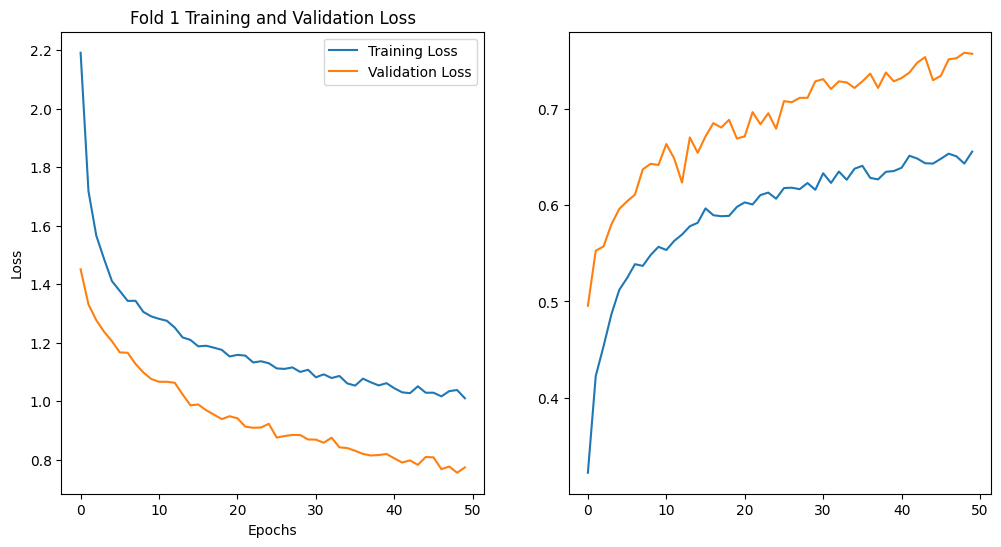

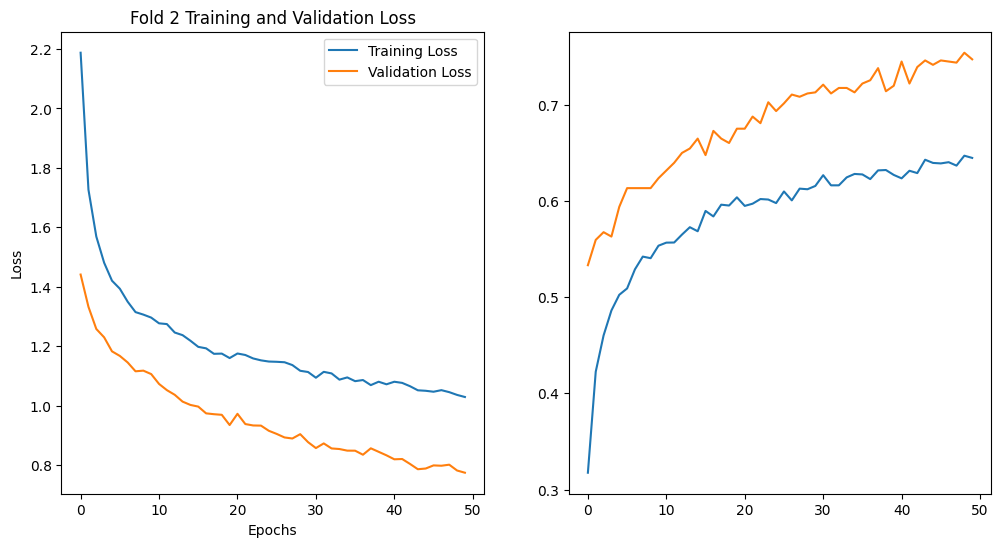

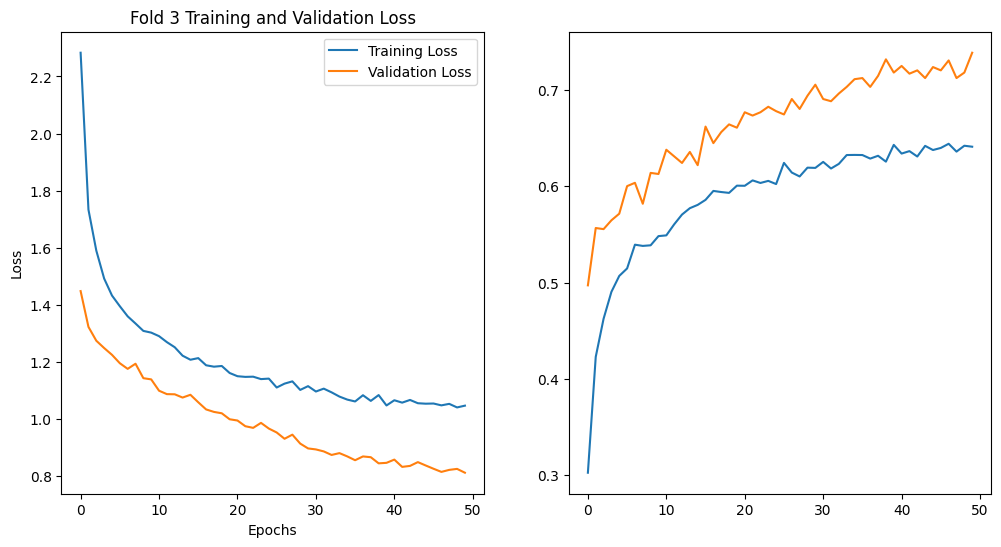

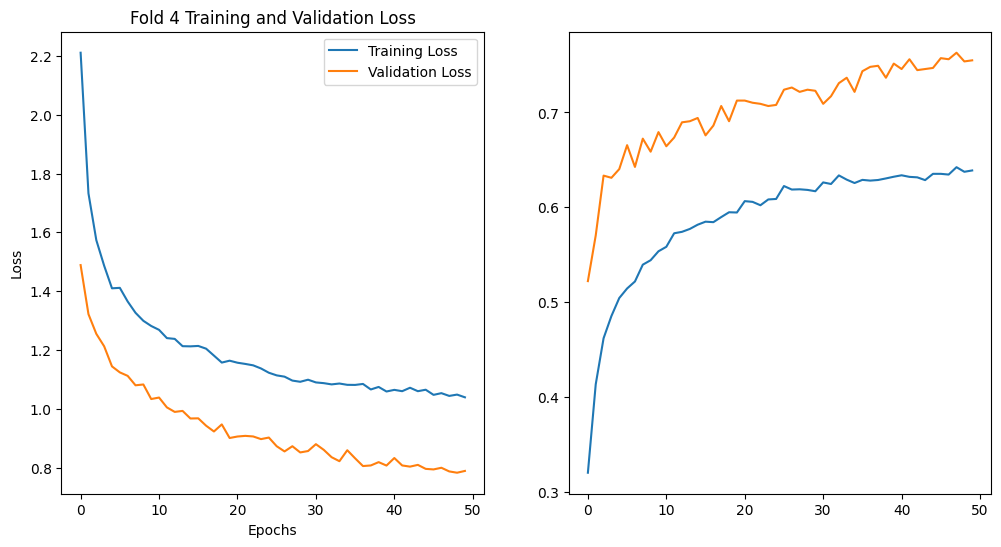

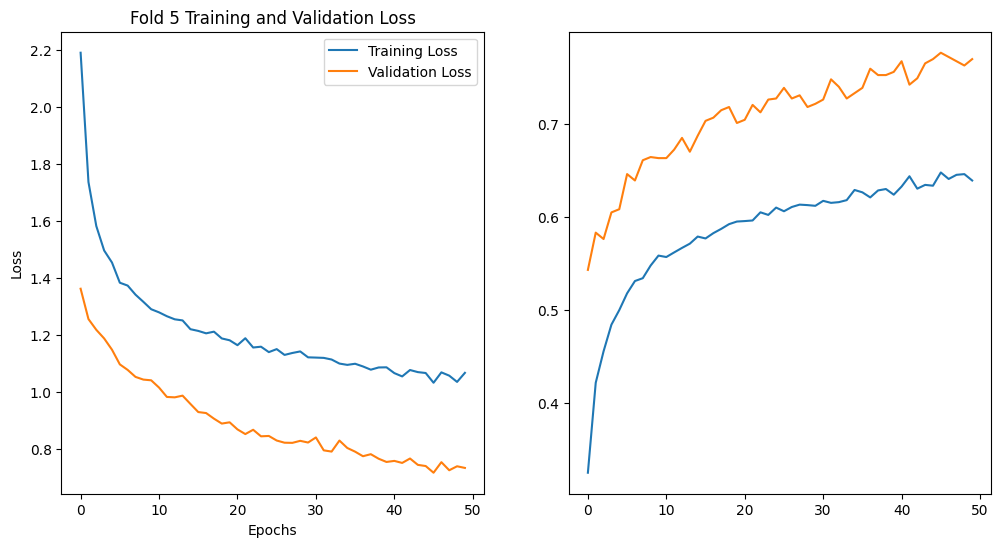

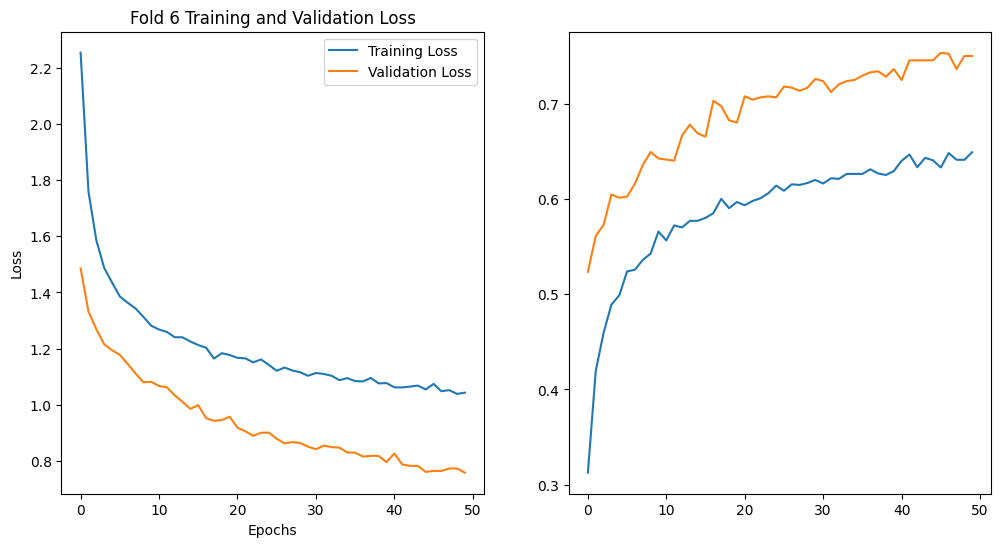

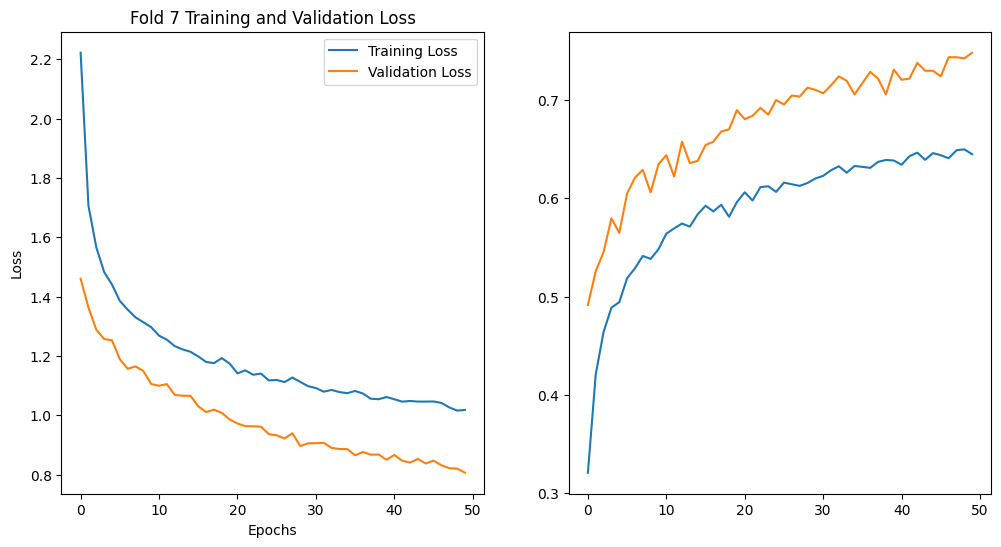

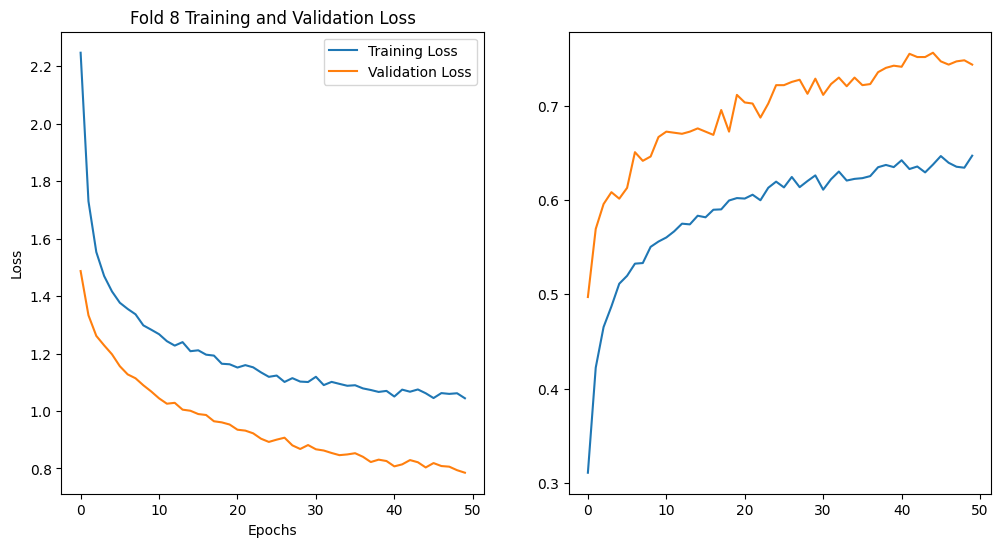

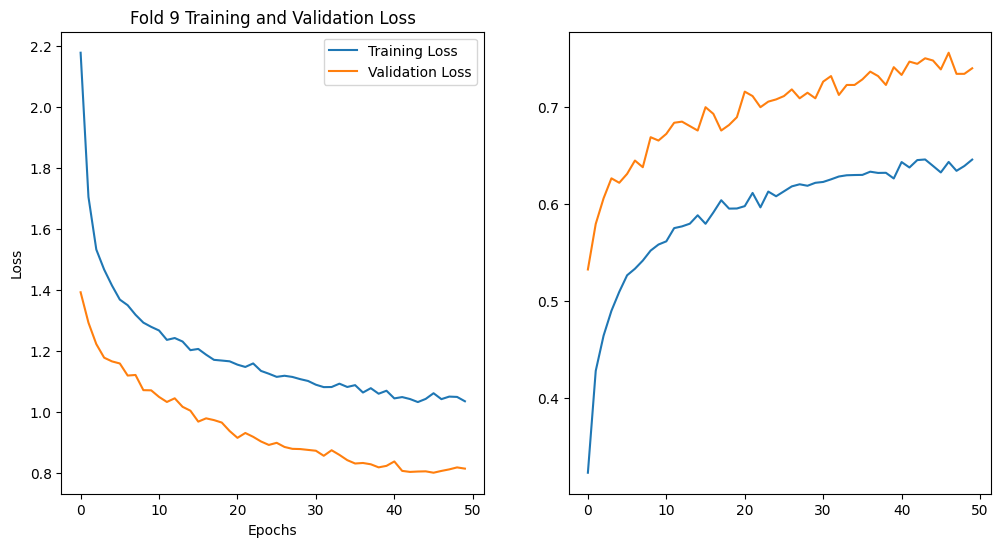

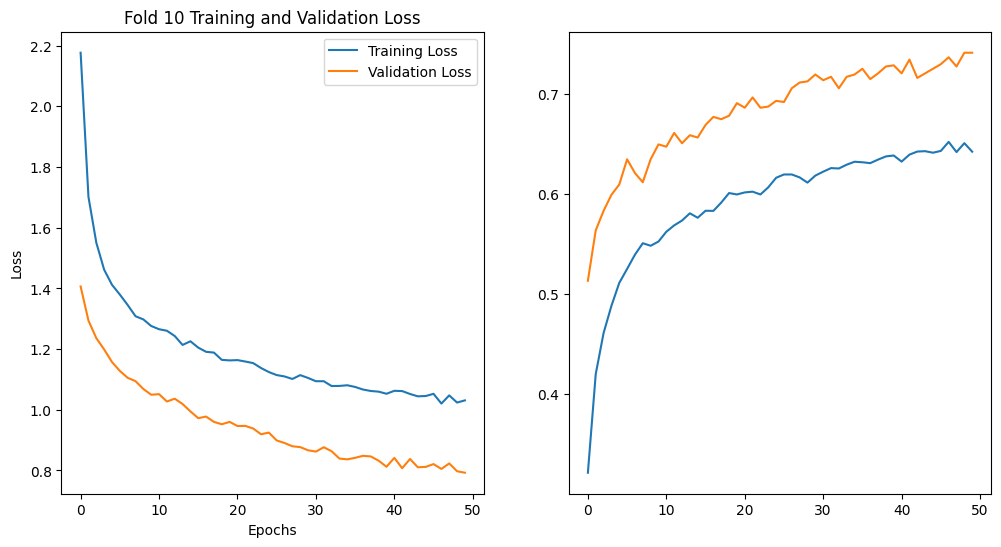

In [37]:
# Convert the label list to numpy array
#labels = np.array(label_list)

# Encode class labels to integers
labelsfit = label_encoder.fit_transform(labels)

# Define the number of folds
n_folds = 10

# Initialize StratifiedKFold
kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# Lists to store results for each fold
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Iterate through each fold
for fold_idx, (train_index, test_index) in enumerate(kf.split(np.array(feature_list), labelsfit), start=1):
    X_train, X_test = np.array(feature_list)[train_index], np.array(feature_list)[test_index]
    y_train, y_test = labelsfit[train_index], labelsfit[test_index]

    # Build and compile the model
    model = Sequential([
        Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(len(label_encoder.classes_), activation='softmax')
    ])
    
    model.compile(optimizer=Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, verbose=0)

    # Evaluate the model on both training and testing sets for this fold
    train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    
    # Save the model
    model.save(f'UrbanSound8K_fold{fold_idx}.h5')
    
    # Print out the fold number and results
    print(f'Fold {fold_idx}:')
    print(f'Training Loss: {train_loss:.4f}')
    print(f'Training Accuracy: {train_accuracy:.4f}')
    print(f'Testing Loss: {test_loss:.4f}')
    print(f'Testing Accuracy: {test_accuracy:.4f}')
    print('-' * 40)

    # Plot training history for each fold
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Fold {fold_idx} Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title

Audio Classification

In [1]:
from kafka import KafkaProducer
import sounddevice as sd

producer = KafkaProducer(bootstrap_servers=['127.0.0.1:9092'])

#Set the duration and sampling rate
duration = 5.5  # seconds
sample_rate = 44100 # Hz

# Record audio and save as a .wav file
recording = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=1)
sd.wait()

# Send the audio data to the Kafka topic
producer.send("test1", value=recording.tobytes())

producer.close()


In [3]:
from kafka import KafkaProducer
import sounddevice as sd
import librosa
import numpy as np
from tensorflow import keras

producer = KafkaProducer(bootstrap_servers=['127.0.0.1:9092'])

#Set the total run time
hours = 0
minutes = 1
seconds = 0

# Set the clip duration and sampling rate
duration = 5.5  # seconds
sample_rate = 44100 # Hz

# number of loops needed to run for the total run time
loops = round((hours*60*60 + minutes*60 + seconds) / duration)

# Iterate over loops
for i in range (loops):
    # Record audio and save as a .wav file
    recording = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=1)
    sd.wait()

    # Extract features from the audio clip
    features = librosa.feature.mfcc(y=recording.flatten(), sr=sample_rate, n_mfcc=13)
    features = np.mean(features.T, axis=0)

    # Load the trained model and predict the class label
    model = keras.models.load_model('UrbanSound8K_model1.h5')
    class_label = model.predict(np.array([features]))

    # Send the audio data and prediction to the Kafka topic
    producer.send("test3", value=recording.tobytes(), key=str(class_label).encode("utf-8"))
    
    # Print a message to indicate the clip has been processed
    print(f'Audio clip {i+1} processed and sent to Kafka topic')

producer.close()


1/1 [==============================] - 0s 138ms/step
Audio clip 1 processed and sent to Kafka topic
1/1 [==============================] - 0s 52ms/step
Audio clip 2 processed and sent to Kafka topic
1/1 [==============================] - 0s 53ms/step
Audio clip 3 processed and sent to Kafka topic
1/1 [==============================] - 0s 55ms/step
Audio clip 4 processed and sent to Kafka topic
1/1 [==============================] - 0s 53ms/step
Audio clip 5 processed and sent to Kafka topic
1/1 [==============================] - 0s 53ms/step
Audio clip 6 processed and sent to Kafka topic
1/1 [==============================] - 0s 49ms/step
Audio clip 7 processed and sent to Kafka topic
1/1 [==============================] - 0s 56ms/step
Audio clip 8 processed and sent to Kafka topic
1/1 [==============================] - 0s 53ms/step
Audio clip 9 processed and sent to Kafka topic
1/1 [==============================] - 0s 53ms/step
Audio clip 10 processed and sent to Kafka topic
1/1 [===

In [13]:
from kafka import KafkaConsumer
import numpy as np
import sounddevice as sd

# Create a KafkaConsumer instance
consumer = KafkaConsumer(
    'test3',
    bootstrap_servers=['127.0.0.1:9092'], 
    auto_offset_reset='earliest')

# Decode the audio data and print the predicted class label of the first 3 messages
for message in consumer:
    audio_data = np.frombuffer(message.value, dtype=np.int32)
    print(f'Predicted class: {message.key.decode("utf-8")}')
    sd.play(audio_data, 44100)
    print(f'Audio data: {audio_data}')
    print('-' * 40)
    
    if message.offset == 2:
        consumer.close()

Predicted class: [[5.4989650e-05 3.0736090e-04 6.6931117e-01 1.1588755e-01 3.6850519e-04
  8.3640672e-04 3.8402513e-02 3.8266106e-09 6.8798186e-03 1.6795178e-01]]
Audio data: [          0           0 -1207959552 ... -1136001024 -1134886912
 -1133477888]
----------------------------------------
Predicted class: [[6.16571284e-04 1.16378513e-04 2.04684630e-01 3.12261313e-01
  2.03947115e-04 1.86100078e-04 2.27028318e-02 2.25905947e-10
  1.51138725e-02 4.44114268e-01]]
Audio data: [          0           0 -1207959552 ... -1109938176 -1110048768
 -1109946368]
----------------------------------------
Predicted class: [[5.1645250e-03 2.5687509e-04 1.6987769e-01 3.8569447e-01 5.1790185e-04
  5.9416733e-04 3.9722186e-02 3.6008024e-10 4.9075060e-02 3.4909716e-01]]
Audio data: [          0           0 -1207959552 ...  1003683840  1003814912
  1002242048]
----------------------------------------


In [62]:
from kafka import KafkaConsumer
import numpy as np

# Create a KafkaConsumer instance
consumer = KafkaConsumer(
    'test2',
    bootstrap_servers=['127.0.0.1:9092'], 
    auto_offset_reset='earliest')

# List messages from the Kafka topic decoding the keys and values
for message in consumer:
         # Consume the message
    message = consumer.poll()
    if message is not None:
        # Get the message from the dictionary
        message = message[0]

        # Decode the tobytes() value
        recording = np.frombuffer(message.value, dtype=np.int16)

        # Play the audio clip
        sd.play(recording, 44100)
        sd.wait()

        # Decode the key
        class_label = message.key.decode('utf-8')

        # Print the class label
        print(class_label)

consumer.close()


KeyError: 0

In [ ]:
from kafka import KafkaConsumer

consumer = KafkaConsumer("test2", bootstrap_servers=['127.0.0.1:9092'])

# Consume all of the messages in the topic
for message in consumer:
    print(f'Key: {message.key.decode("utf-8")}, Value: {message.value}') 
    
# Close the KafkaConsumer instance
consumer.close()